# RNN and LSTM
- Each observation is a time series. This notebook aims to try the RNN method for single time series

In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [21]:
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.preprocessing import MinMaxScaler

In [106]:
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

In [107]:
from sklearn.metrics import mean_squared_error
from math import sqrt

In [23]:
df_cal0 = pd.read_csv('/Users/yanzeliu/Downloads/m5-forecasting-accuracy/calendar.csv')
df_train0 = pd.read_csv("/Users/yanzeliu/Downloads/m5-forecasting-accuracy/sales_train_validation.csv")
df_price0 = pd.read_csv("/Users/yanzeliu/Downloads/m5-forecasting-accuracy/sell_prices.csv")

In [24]:
df_train0.head()

,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,...,d_1904,d_1905,d_1906,d_1907,d_1908,d_1909,d_1910,d_1911,d_1912,d_1913
0,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,3,0,1,1,1,3,0,1,1
1,HOBBIES_1_002_CA_1_validation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2,HOBBIES_1_003_CA_1_validation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,2,1,2,1,1,1,0,1,1,1
3,HOBBIES_1_004_CA_1_validation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,0,5,4,1,0,1,3,7,2
4,HOBBIES_1_005_CA_1_validation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,2,1,1,0,1,1,2,2,2,4


## Convert the first row to time series data type
- Use the first row: HOBBIES_1_001, from CA_1
- The timeline is 2011-01-29 to 2016-06-19: This is the whole 1969 days 
- The given training data is from 2011-01-29 to 2016-04-24
- The validation time period is from 2016-04-25 to 2016-06-19
- The data look rather **stationary**

In [25]:
# create time series index
idx_train = pd.date_range(start='2011-01-29', periods=1913, freq='D')
#idx_val = pd.date_range(start='2016-04-25', periods=28, freq='D') #For validation time period
#idx_eval = pd.date_range(start='2016-05-23', periods=28, freq='D') #For evaluation time period

In [26]:
df_row1 = pd.DataFrame(df_train0.iloc[1000,6:].transpose())
df_row1.columns = ["Item_Sales"]
#df_row1.head()

In [27]:
# change the original index to datetime index
df_row1.set_index(idx_train, inplace=True)

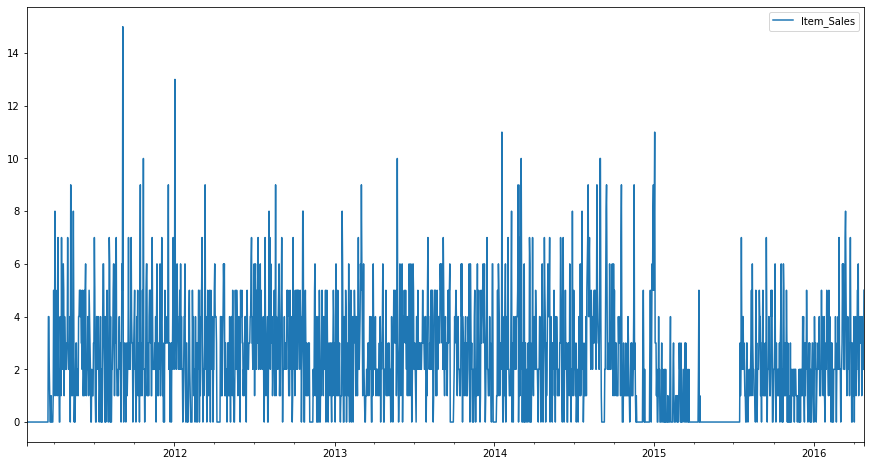

In [28]:
# visualize the one row
df_row1.plot(kind='line', figsize=(15,8))

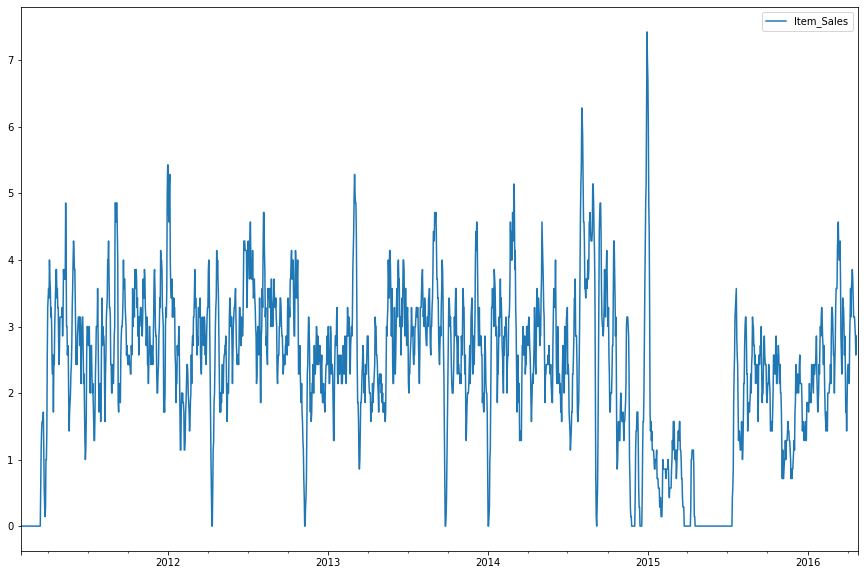

In [54]:
# times series decompose results
df_row1 = df_row1.astype(int)
tsa_decompose = seasonal_decompose(df_row1)
tsa_decompose.trend.plot(figsize=(15,10));

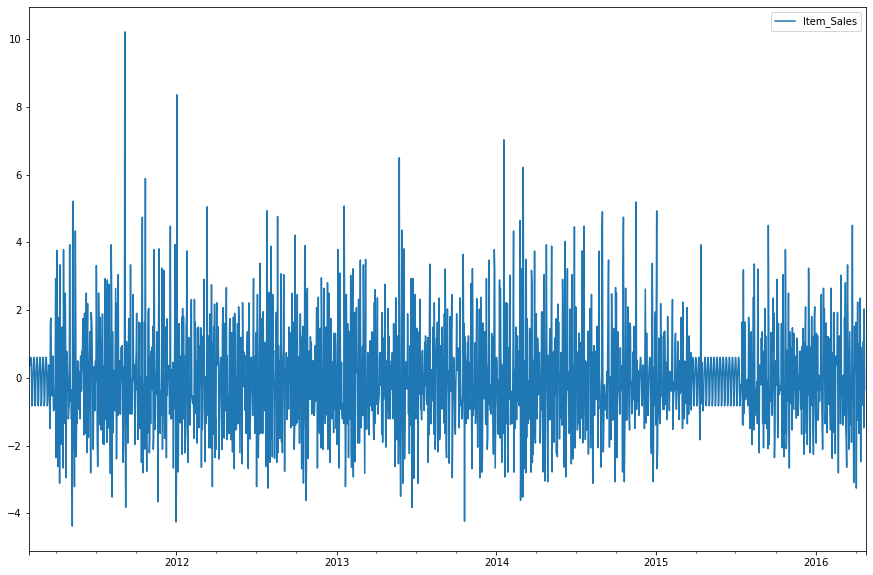

In [55]:
tsa_decompose.resid.plot(figsize=(15,10));

## Process RNN with the one item

In [56]:
# transpose the original dataframe
df_train1 = df_train0.iloc[:,6:].transpose()

In [57]:
# set the datetime index
df_train1.set_index(idx_train, inplace=True)

In [58]:
df_train1.head()

,0,1,2,3,4,5,6,7,8,9,...,30480,30481,30482,30483,30484,30485,30486,30487,30488,30489
2011-01-29,0,0,0,0,0,0,0,12,2,0,...,0,14,1,0,4,0,0,0,0,0
2011-01-30,0,0,0,0,0,0,0,15,0,0,...,0,11,1,0,4,0,0,6,0,0
2011-01-31,0,0,0,0,0,0,0,0,7,1,...,0,5,1,0,2,2,0,0,0,0
2011-02-01,0,0,0,0,0,0,0,0,3,0,...,0,6,1,0,5,2,0,2,0,0
2011-02-02,0,0,0,0,0,0,0,0,0,0,...,0,5,1,0,2,0,0,2,0,0


**transform all items**

In [69]:
# separate train and validation
df_train2 = df_train1.iloc[0:-28,]
df_val2 = df_train1.iloc[-28:,]

In [70]:
# scale the dataset
scaler = MinMaxScaler().fit(df_train2)
train_scale = scaler.transform(df_train2)
val_scale = scaler.transform(df_val2)

In [152]:
#train_scale[:,0]

In [61]:
#train_scale = train_scale.reshape(1885, 30490,1)

In [153]:
#train_scale[:,0]

In [71]:
train_scale[0:10,0:5]
train_scale[:,0].shape

(1885,)

### Preparation for RNN input

In [72]:
n_input = 7
n_features = train_scale.shape[1]

In [73]:
ts_generator = TimeseriesGenerator(train_scale, train_scale, length=n_input, batch_size=128)

In [74]:
X,y = ts_generator[0]
X.shape
#y.shape

(128, 7, 30490)

In [78]:
# define model
model = Sequential()
model.add(LSTM(100, activation='relu', input_shape=(n_input, n_features)))
model.add(Dense(30490))
model.compile(optimizer='adam', loss='mse')

In [79]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 100)               12236400  
_________________________________________________________________
dense_2 (Dense)              (None, 30490)             3079490   
Total params: 15,315,890
Trainable params: 15,315,890
Non-trainable params: 0
_________________________________________________________________


In [80]:
# fit model
model.fit_generator(ts_generator,epochs=30)

Epoch 1/30
15/15 [==============================] - 14s 940ms/step - loss: 0.0211
Epoch 2/30
15/15 [==============================] - 10s 678ms/step - loss: 0.0178
Epoch 3/30
15/15 [==============================] - 10s 649ms/step - loss: 0.0151
Epoch 4/30
15/15 [==============================] - 12s 809ms/step - loss: 0.0145
Epoch 5/30
15/15 [==============================] - 12s 777ms/step - loss: 0.0141
Epoch 6/30
15/15 [==============================] - 10s 656ms/step - loss: 0.0140
Epoch 7/30
15/15 [==============================] - 10s 691ms/step - loss: 0.0140
Epoch 8/30
15/15 [==============================] - 9s 624ms/step - loss: 0.0139
Epoch 9/30
15/15 [==============================] - 9s 615ms/step - loss: 0.0138
Epoch 10/30
15/15 [==============================] - 9s 628ms/step - loss: 0.0137
Epoch 11/30
15/15 [==============================] - 10s 642ms/step - loss: 0.0137
Epoch 12/30
15/15 [==============================] - 9s 595ms/step - loss: 0.0137
Epoch 13/30
15/15

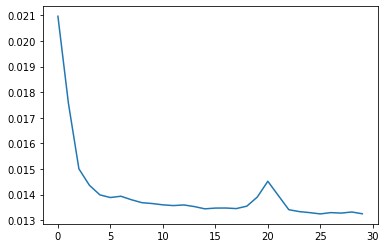

In [81]:
loss_per_epoch = model.history.history['loss']
plt.plot(range(len(loss_per_epoch)),loss_per_epoch)

### model validation

In [90]:
first_eval_batch = train_scale[-7:]
first_eval_batch = first_eval_batch.reshape((1, n_input, n_features))

In [96]:
print('the first forecase result is {}'.format(model.predict(first_eval_batch)[0][0:20]))
print('the first true validation is {}'.format(val_scale[0][0:20]))

the first forecase result is [0.14032005 0.05695592 0.06472505 0.15497504 0.11160977 0.06830988
 0.1036786  0.11570154 0.0191652  0.101611   0.02686645 0.07431163
 0.08300652 0.11820116 0.06156191 0.06334841 0.07846562 0.01426885
 0.11626187 0.07269001]
the first true validation is [0.2        0.2        0.         0.         0.11111111 0.
 0.33333333 0.         0.         0.         0.         0.33333333
 0.         0.2        0.04819277 0.02222222 0.         0.
 0.078125   0.        ]


**prediction for 28 days**

In [97]:
test_predictions = []

first_eval_batch = train_scale[-n_input:]
current_batch = first_eval_batch.reshape((1, n_input, n_features))

In [98]:
current_batch.shape

(1, 7, 30490)

In [112]:
test_predictions = []

first_eval_batch = train_scale[-n_input:]
current_batch = first_eval_batch.reshape((1, n_input, n_features))

for i in range(len(val_scale)):
    
    # get prediction 1 time stamp ahead ([0] is for grabbing just the number instead of [array])
    current_pred = model.predict(current_batch)[0]
    
    # store prediction
    test_predictions.append(current_pred) 
    
    # update batch to now include prediction and drop first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

In [105]:
test_predictions[0].shape

(30490,)

In [109]:
rms = sqrt(mean_squared_error(val_scale, test_predictions))

In [110]:
rms

0.14588208820730214